In [10]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

from typing import List

import numpy as np
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, isnan, when
from pyspark.sql.types import IntegerType, DoubleType, BooleanType

In [2]:
spark = SparkSession.builder.appName("diabetes_indicators").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 22:17:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load the Dataset

In [6]:
df_male = spark.read.csv("./data/diabetes/diabetes_male_data_with_missing.csv", header=True, inferSchema=True)
df_male.show(5, truncate=False)

+------------+---+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+----+---------+------+
|Diabetes_012|Sex|HighBP|HighChol|CholCheck|BMI |Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Age |Education|Income|
+------------+---+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+----+---------+------+
|0.0         |1.0|1.0   |1.0     |1.0      |25.0|1.0   |0.0   |0.0                 |1.0         |1.0   |1.0    |0.0              |1.0          |0.0        |2.0    |0.0     |2.0     |0.0     |10.0|6.0      |8.0   |
|0.0         |1.0|0.0   |0.0     |1.0      |24.0|0.0   |0.0   |0.0                 |0.0         |0.0   |1.0    |0.0              |1.0          |

In [7]:
df_female = spark.read.csv("./data/diabetes/diabetes_female_data_with_missing.csv", header=True, inferSchema=True)
df_female.show(5, truncate=False)

+------------+---+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+----+---------+------+
|Diabetes_012|Sex|HighBP|HighChol|CholCheck|BMI |Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Age |Education|Income|
+------------+---+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+----+---------+------+
|0.0         |0.0|1.0   |1.0     |1.0      |40.0|1.0   |0.0   |0.0                 |0.0         |0.0   |1.0    |0.0              |1.0          |0.0        |5.0    |18.0    |15.0    |1.0     |9.0 |4.0      |3.0   |
|0.0         |0.0|0.0   |0.0     |0.0      |25.0|1.0   |0.0   |0.0                 |1.0         |0.0   |0.0    |0.0              |0.0          |

In [8]:
print(f"Number of records in Male: {df_male.count()}")
print(f"Number of records in Female: {df_female.count()}")

Number of records in Male: 111706
Number of records in Female: 141974


In [13]:
def unionAll(dfs: List):
    """ Function to merge two sources of data """
    unioned_df = functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)
    return unioned_df

In [15]:
df = unionAll([df_male, df_female])

In [18]:
assert df.columns == df_male.columns and df.columns == df_female.columns, "There has been a join error"

In [19]:
df.columns

['Diabetes_012',
 'Sex',
 'HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Age',
 'Education',
 'Income']

# Data Exploration

## - Data Statistics

In [20]:
df.describe().toPandas()

,summary,Diabetes_012,Sex,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,...,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,count,253680,253680,253426,253399,253438,253431,253419,253425,253418,...,253425,253426,253449,253422,253430,253438,253433,253435,253426,253422
1,mean,0.29692131819615264,0.4403421633554084,0.42895361959704215,0.4241058567713369,0.9626733165507935,28.381812011948025,0.4431830288968073,0.0405682154483575,0.09420009628361048,...,0.056194140278188816,0.9510429079889199,0.08420234445588659,2.5114394172565917,3.1849544252850888,4.242000015782953,0.1682417049082006,8.031925345749404,5.050365787251505,6.053945592726756
2,stddev,0.6981597284091002,0.4964291631185051,0.4949276496613504,0.49420748970763884,0.18956145160935683,6.608456343086432,0.49676232301630097,0.1972880861327352,0.2921074713995792,...,0.23029669592882235,0.21577877299924167,0.27769158052955173,1.0684843884166626,7.412999739742032,8.717735348747313,0.37408152293769875,3.0543456336516526,0.9857325517977745,2.071135705415436
3,min,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,max,2.0,1.0,1.0,1.0,1.0,98.0,1.0,1.0,1.0,...,1.0,1.0,1.0,5.0,30.0,30.0,1.0,13.0,6.0,8.0


## - Missing Data Statistics

In [21]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-------------------
 Diabetes_012         | 0   
 Sex                  | 0   
 HighBP               | 254 
 HighChol             | 281 
 CholCheck            | 242 
 BMI                  | 249 
 Smoker               | 261 
 Stroke               | 255 
 HeartDiseaseorAttack | 262 
 PhysActivity         | 263 
 Fruits               | 249 
 Veggies              | 251 
 HvyAlcoholConsump    | 255 
 AnyHealthcare        | 254 
 NoDocbcCost          | 231 
 GenHlth              | 258 
 MentHlth             | 250 
 PhysHlth             | 242 
 DiffWalk             | 247 
 Age                  | 245 
 Education            | 254 
 Income               | 258 



## - Data Info

In [22]:
df.printSchema()

root
 |-- Diabetes_012: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [23]:
casted_cols = list()
for colname in df.columns:
    if colname not in ["BMI", "PhysHlth", "MentHlth"]:
        casted_cols.append(f"cast({colname} as int) {colname}")
    else:
        casted_cols.append(f"cast({colname} as double) {colname}")

        
df = df.selectExpr(*casted_cols)
df.printSchema()

root
 |-- Diabetes_012: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- HighBP: integer (nullable = true)
 |-- HighChol: integer (nullable = true)
 |-- CholCheck: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: integer (nullable = true)
 |-- Stroke: integer (nullable = true)
 |-- HeartDiseaseorAttack: integer (nullable = true)
 |-- PhysActivity: integer (nullable = true)
 |-- Fruits: integer (nullable = true)
 |-- Veggies: integer (nullable = true)
 |-- HvyAlcoholConsump: integer (nullable = true)
 |-- AnyHealthcare: integer (nullable = true)
 |-- NoDocbcCost: integer (nullable = true)
 |-- GenHlth: integer (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- Income: integer (nullable = true)



## - Data Visualization

### - Single Source of Data Visualization

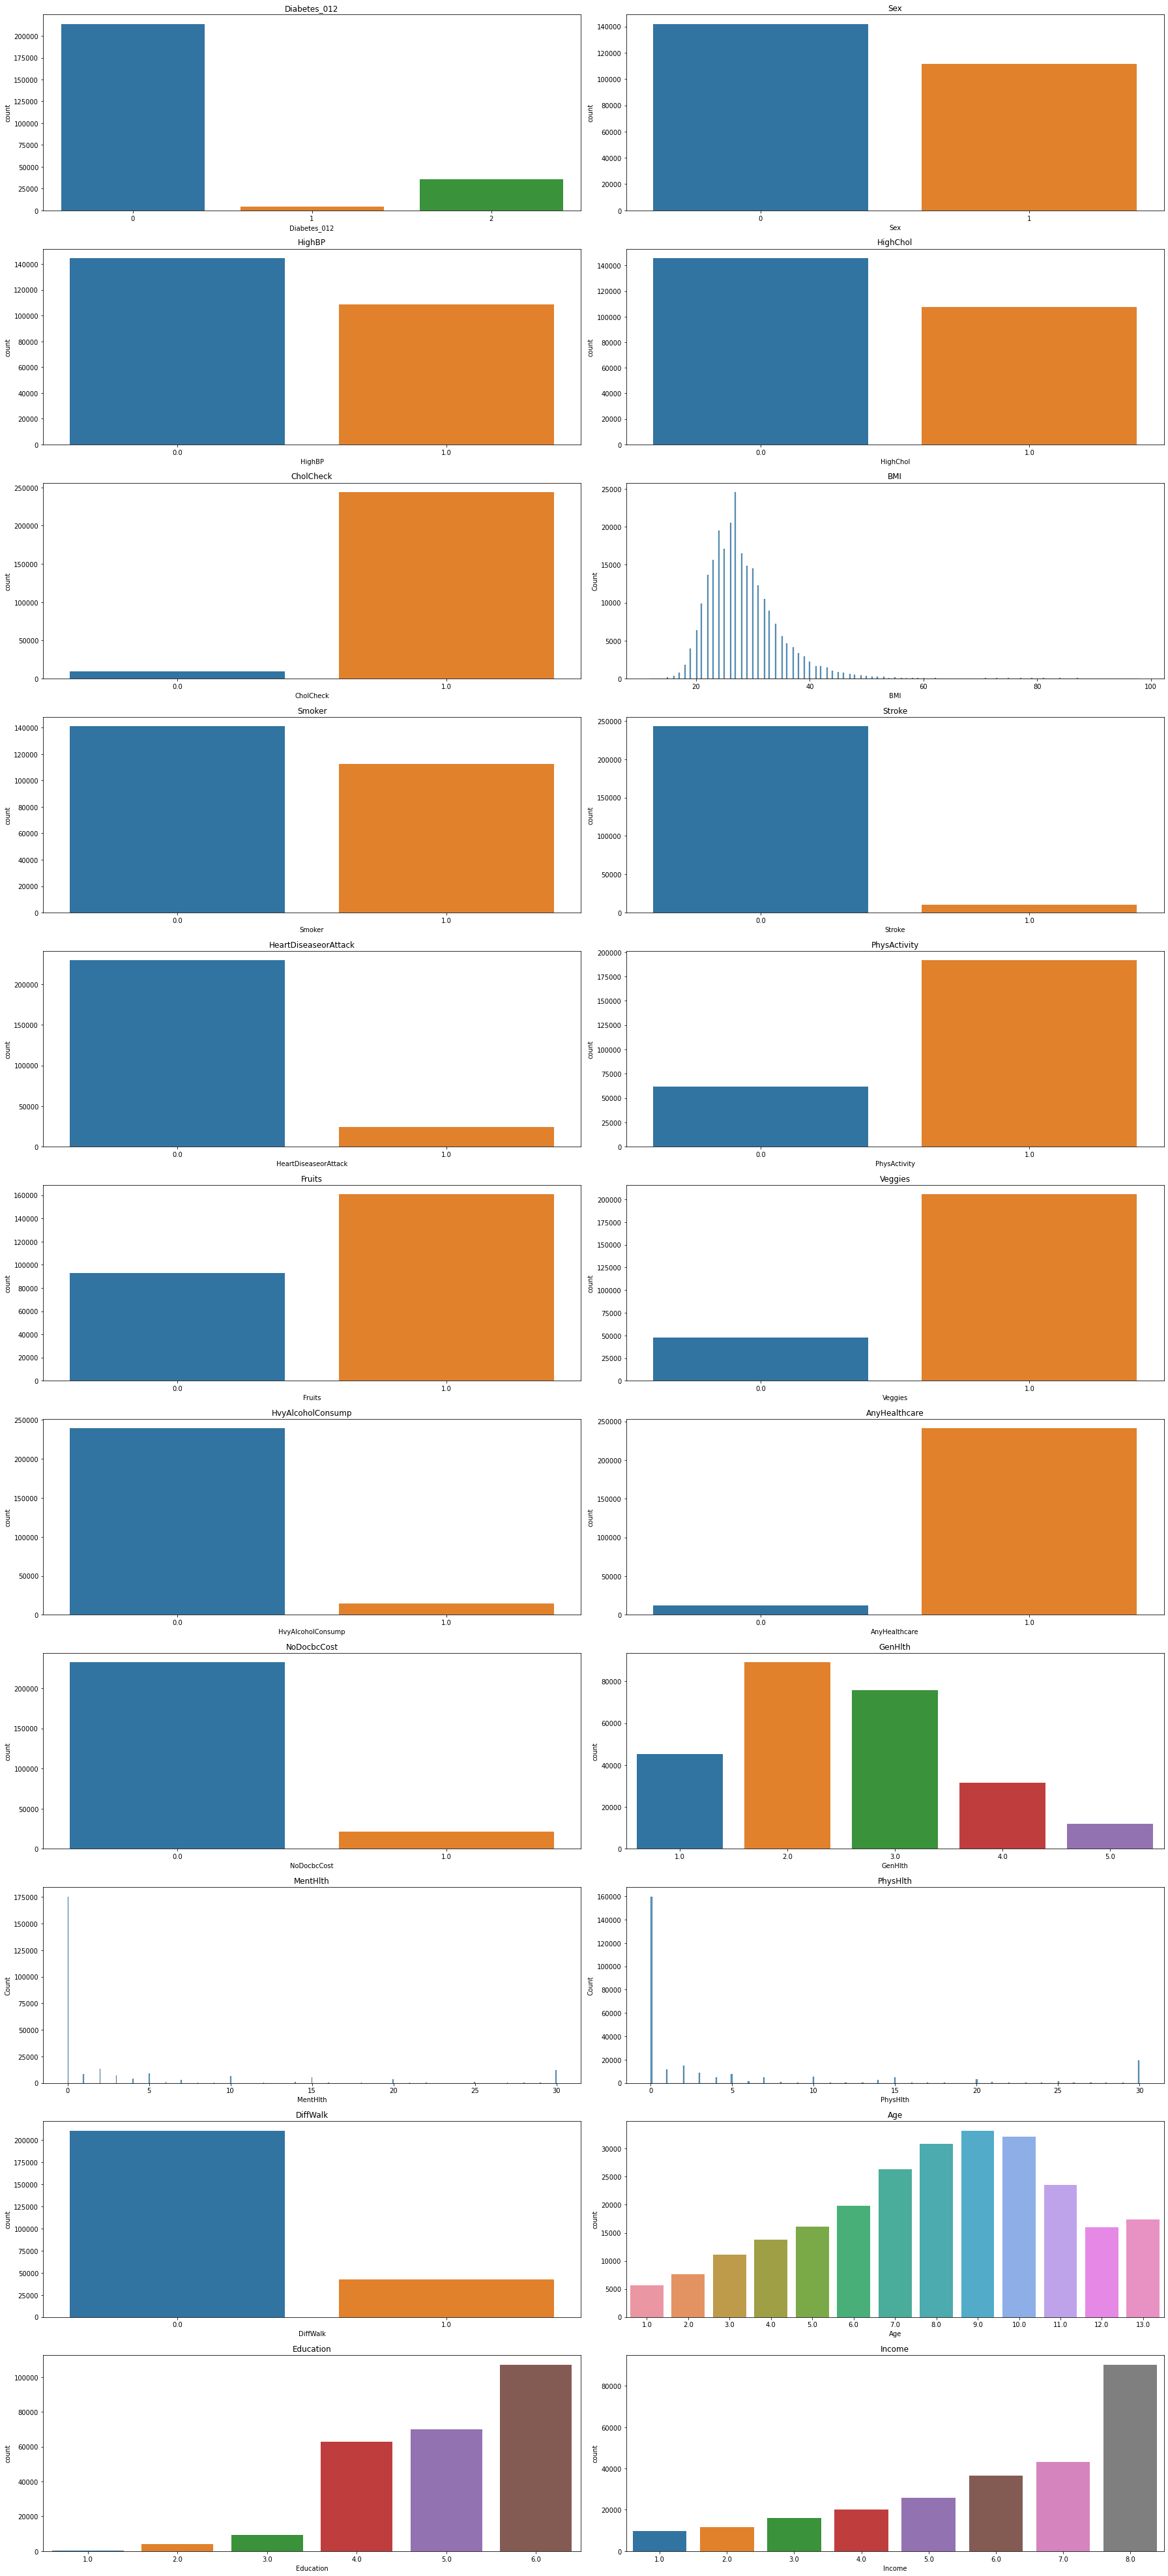

In [24]:
fig, axs = plt.subplots(11, 2, figsize=(25, 55))
axs = axs.flatten()

for idx, colname in enumerate(df.columns):
    axs[idx].set_title(f"{colname}")
    if colname not in ["PhysHlth", "MentHlth", "BMI"]:
        sns.countplot(x=colname, data=df.select(colname).toPandas(), ax=axs[idx])
    else:
        sns.histplot(x=colname, data=df.select(colname).toPandas(), ax=axs[idx])

plt.tight_layout()
plt.show()

In [25]:
if not os.path.exists("./media"):
    os.mkdir("./media")
fig.savefig("./media/categorical_single_dist.png")

### - Correlation between BMI and different variables

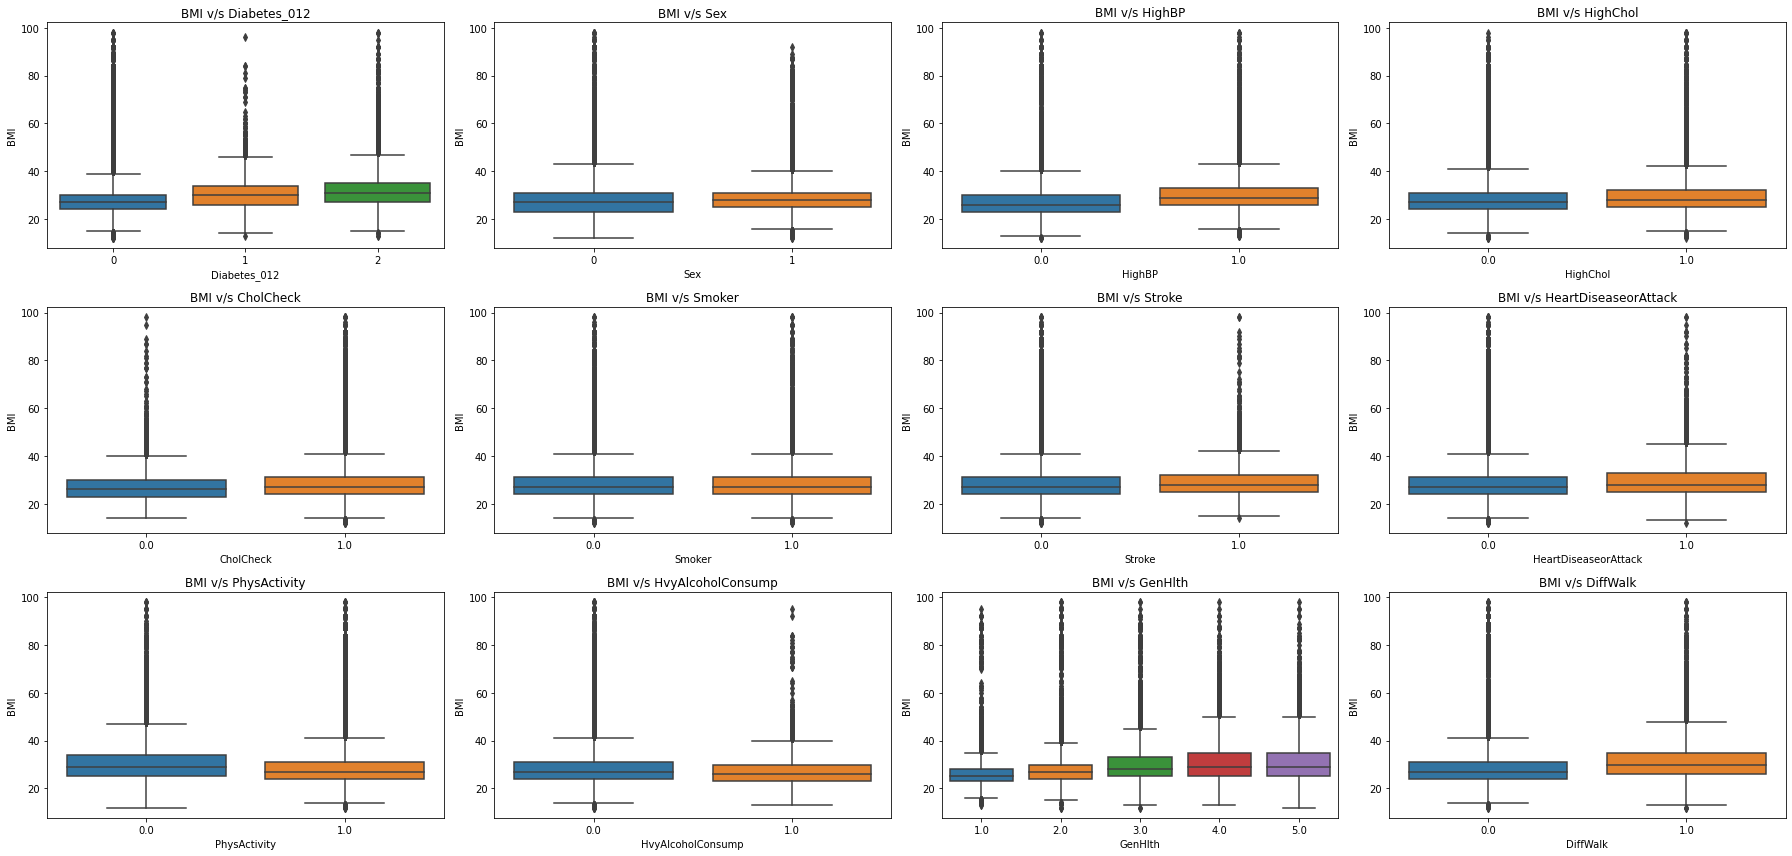

In [26]:
fig, axs = plt.subplots(3, 4, figsize=(25, 12))
axs = axs.flatten()

req_col = list(filter(lambda x: x not in  ["Fruits", "Veggies", "AnyHealthcare", "NoDocbcCost", "MentHlth", "PhysHlth", 
                                           "Age", "Education", "Income", "BMI"], df.columns))


for i, colname in enumerate(req_col):
    axs[i].set_title(f"BMI v/s {colname}")
    sns.boxplot(x=colname, y="BMI", data=df.select(colname, "BMI").toPandas(), ax=axs[i])

plt.tight_layout()
plt.show()

In [27]:
fig.savefig("./media/bmi_vs_other_cats.png")

### - Correlation between Diabetes and PhysHlth

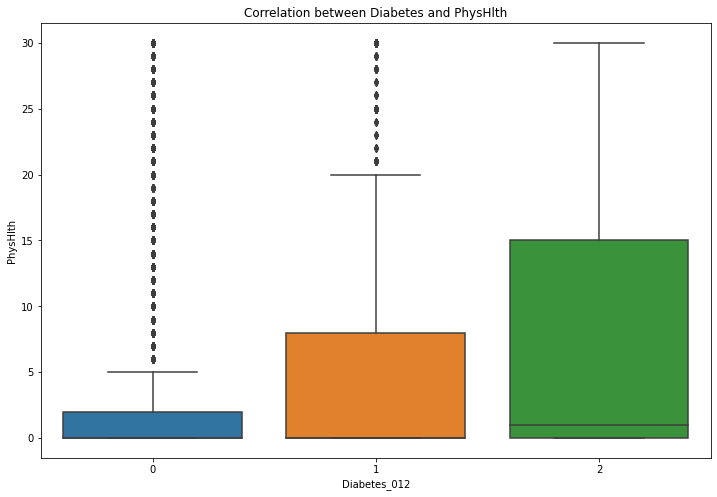

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("Correlation between Diabetes and PhysHlth")
sns.boxplot(x="Diabetes_012", y="PhysHlth", data=df.select("Diabetes_012", "PhysHlth").toPandas(), ax=ax)
plt.show()

In [29]:
fig.savefig("./media/corr_diabetes_physhlth.png")

### - Correlation between MentlHlth and Diabetes

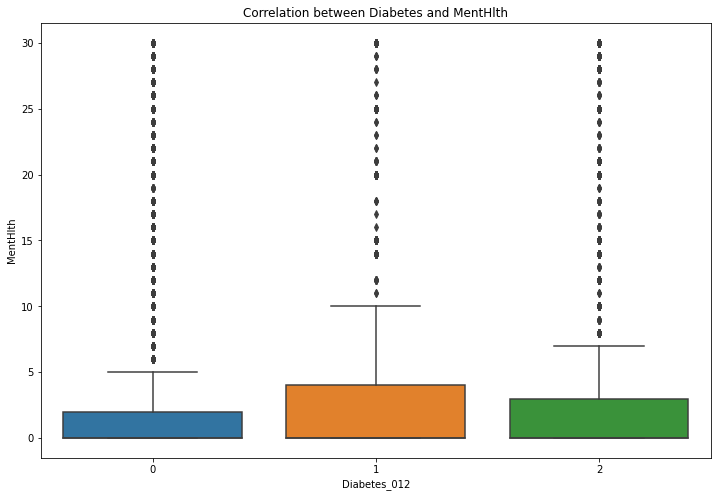

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("Correlation between Diabetes and MentHlth")
sns.boxplot(x="Diabetes_012", y="MentHlth", data=df.select("Diabetes_012", "MentHlth").toPandas(), ax=ax)
plt.show()

In [31]:
fig.savefig("./media/corr_diabetes_mnthlth.png")

### - Correlation between Diabetes and Smoker

In [32]:
df.select("Diabetes_012", "Smoker").na.drop().crosstab("Diabetes_012", "Smoker").show()

+-------------------+------+-----+
|Diabetes_012_Smoker|     0|    1|
+-------------------+------+-----+
|                  1|  2344| 2277|
|                  0|121745|91746|
|                  2| 17019|18288|
+-------------------+------+-----+



### - Correlation between Diabetes and High Cholestrol

In [33]:
df.select("Diabetes_012", "HighChol").na.drop().crosstab("Diabetes_012", "HighChol").show()

+---------------------+------+-----+
|Diabetes_012_HighChol|     0|    1|
+---------------------+------+-----+
|                    1|  1756| 2870|
|                    0|132527|80937|
|                    2| 11648|23661|
+---------------------+------+-----+



### - Correlation between Diabetes and Fruits

In [34]:
df.select("Diabetes_012", "Fruits").na.drop().crosstab("Diabetes_012", "Fruits").show()

+-------------------+-----+------+
|Diabetes_012_Fruits|    0|     1|
+-------------------+-----+------+
|                  1| 1842|  2786|
|                  0|76213|137274|
|                  2|14640| 20676|
+-------------------+-----+------+



### - Correlation between Diabetes and Veggies

In [35]:
df.select("Diabetes_012", "Veggies").na.drop().crosstab("Diabetes_012", "Veggies").show()

+--------------------+-----+------+
|Diabetes_012_Veggies|    0|     1|
+--------------------+-----+------+
|                   1| 1069|  3555|
|                   0|38119|175386|
|                   2| 8597| 26703|
+--------------------+-----+------+



### - Correlation between Diabetes and GenHlth

In [36]:
df.select("Diabetes_012", "GenHlth").na.drop().crosstab("Diabetes_012", "GenHlth").show()

+--------------------+-----+-----+-----+-----+----+
|Diabetes_012_GenHlth|    1|    2|    3|    4|   5|
+--------------------+-----+-----+-----+-----+----+
|                   2| 1139| 6376|13450| 9780|4577|
|                   1|  313| 1212| 1725| 1024| 350|
|                   0|43803|81390|60406|20736|7141|
+--------------------+-----+-----+-----+-----+----+



### - Correlation between HvgAlcoholConsumption and Diabetes

In [37]:
df.select("Diabetes_012", "HvyAlcoholConsump").na.drop().crosstab("Diabetes_012", "HvyAlcoholConsump").show()

+------------------------------+------+-----+
|Diabetes_012_HvyAlcoholConsump|     0|    1|
+------------------------------+------+-----+
|                             1|  4421|  208|
|                             0|200285|13201|
|                             2| 34478|  832|
+------------------------------+------+-----+



### - Correlation between Diabetes and Sex

In [38]:
df.select("Diabetes_012", "Sex").na.drop().crosstab("Diabetes_012", "Sex").show()

+----------------+------+-----+
|Diabetes_012_Sex|     0|    1|
+----------------+------+-----+
|               1|  2604| 2027|
|               2| 18411|16935|
|               0|120959|92744|
+----------------+------+-----+



### - Correlation between Diabetes and Age

In [39]:
df.select("Diabetes_012", "Age").na.drop().crosstab("Diabetes_012", "Age").show()

+----------------+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+
|Diabetes_012_Age|   1|   10|   11|   12|   13|   2|    3|    4|    5|    6|    7|    8|    9|
+----------------+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+
|               2|  78| 6547| 5134| 3400| 3205| 140|  314|  626| 1049| 1740| 3085| 4261| 5732|
|               0|5599|24911|17772|12123|13687|7395|10727|13045|14935|17745|22783|25989|26786|
|               1|  21|  695|  602|  445|  453|  54|   72|  142|  163|  312|  416|  550|  702|
+----------------+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+



### - Correlation between Diabetes and Education

In [40]:
df.select("Diabetes_012", "Education").na.drop().crosstab("Diabetes_012", "Education").show()

+----------------------+---+----+----+-----+-----+-----+
|Diabetes_012_Education|  1|   2|   3|    4|    5|    6|
+----------------------+---+----+----+-----+-----+-----+
|                     2| 47|1182|2294|11055|10344|10391|
|                     1|  2| 161| 314| 1349| 1332| 1469|
|                     0|125|2692|6864|50292|58168|95345|
+----------------------+---+----+----+-----+-----+-----+

